In [150]:
import numpy as np
import pandas as pd

from time import time

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Data collection

In [151]:
def read_tide(filepath, datetime_pattern=slice(0,13)):
    df = pd.read_csv(filepath)
    df['Date Time'] = [date[datetime_pattern] for date in df['Date Time']]
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.groupby(['Date Time']).mean()
    return df.reset_index()

In [152]:
orig_train = read_tide('BHPtraining(1).csv')
orig_test = read_tide('BHPtest.csv')

# Data cleaning

## Convert it to hourly

In [153]:
orig_train

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.90,2.4475,0.1492,4.860,136.111111,5.355556
1,2017-01-01 01:00:00,63.98,2.2461,0.1629,4.237,134.200000,4.666000
2,2017-01-01 02:00:00,64.18,2.2506,0.1539,5.073,129.700000,5.404000
3,2017-01-01 03:00:00,64.30,2.1027,0.1608,5.015,112.200000,5.287000
4,2017-01-01 04:00:00,64.18,2.0279,0.1686,6.725,82.800000,7.115000
...,...,...,...,...,...,...,...
26275,2019-12-31 19:00:00,59.56,0.5822,0.2331,14.929,27.500000,17.630000
26276,2019-12-31 20:00:00,59.27,0.7208,0.2327,14.346,27.900000,17.027000
26277,2019-12-31 21:00:00,59.08,0.9824,0.2450,13.550,28.200000,16.327000
26278,2019-12-31 22:00:00,58.72,1.2382,0.2184,14.112,26.100000,16.619000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6D7737C08>,
      dtype=object)

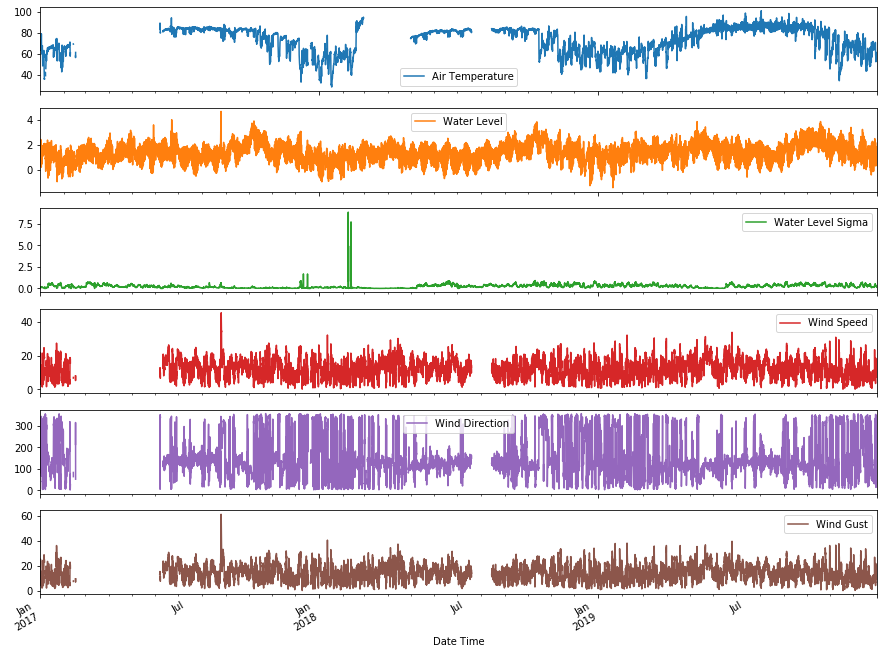

In [154]:
orig_train.plot(x='Date Time', figsize=(15, 12), subplots=True)

## Remove missing values

In [155]:
def clean_tide_data(df):
    cleaned = df.copy()
    cleaned.dropna(inplace=True)
    return cleaned

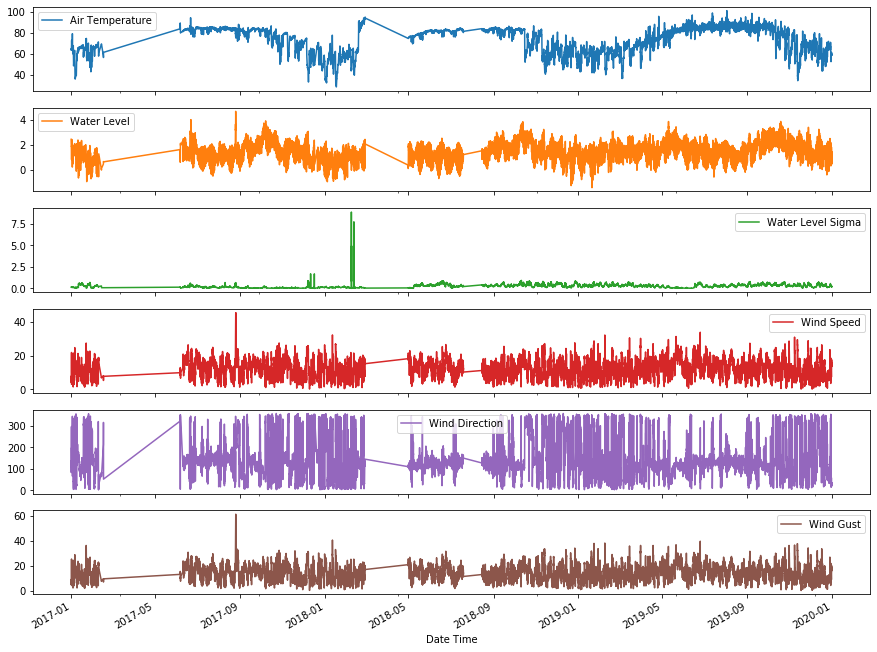

In [156]:
cleaned_train = clean_tide_data(orig_train)
cleaned_train.plot(x='Date Time', figsize=(15, 12), subplots=True)

cleaned_test = clean_tide_data(orig_test)

# Preprocessing

## Stationary

In [157]:
def stationary_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [158]:
# train data
wl_train = orig_train[['Date Time', 'Water Level']].copy().set_index('Date Time')
stationary_test(wl_df['Water Level'].values)

# wl_df = wl_df.diff(periods=1).dropna()
# stationary_test(wl_df['Water Level'])
# plot_water_level(wl_df)

# test data
wl_test = orig_test[['Date Time', 'Water Level']].copy().set_index('Date Time')
stationary_test(wl_df['Water Level'].values)
# wl_test = wl_test.diff(periods=1)
wl_test.dropna(inplace=True)

# wl_df

ADF Statistic: -7.975629
p-value: 0.000000
ADF Statistic: -7.975629
p-value: 0.000000


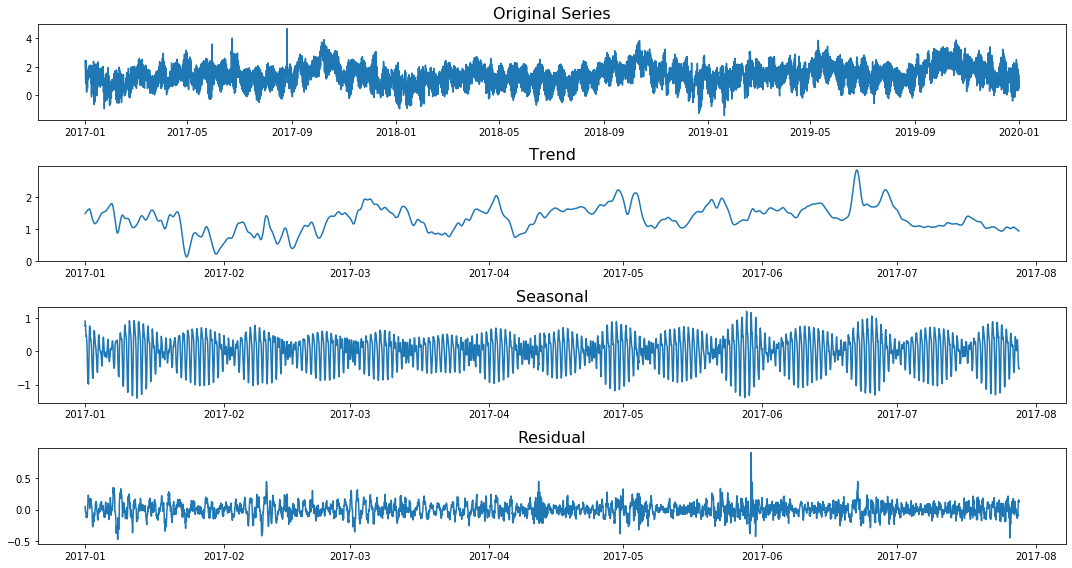

In [159]:
stl = STL(wl_df[:5000])
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(wl_df)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

## ACF and PACF

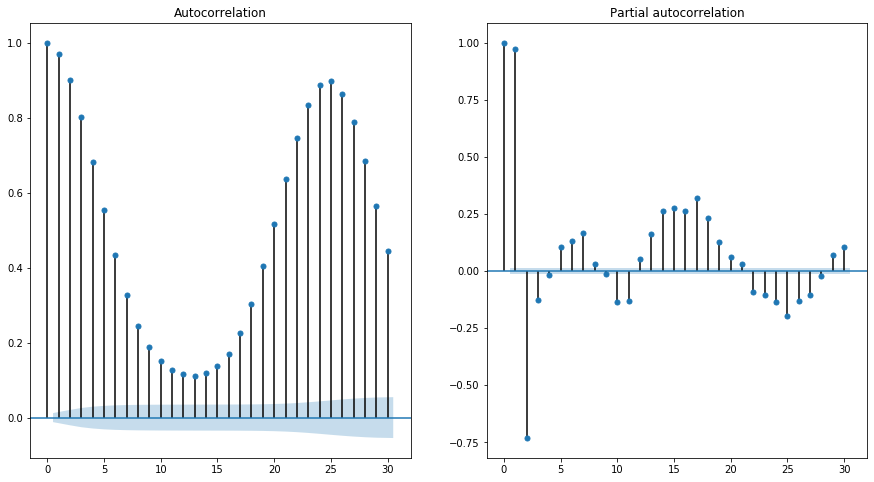

In [160]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
lags = 30
sm.graphics.tsa.plot_acf(wl_df, lags=lags, ax=ax[0], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(wl_df, lags=lags, ax=ax[1], title='Partial autocorrelation')
pass

For ACF, we can see that 25 is the most significant lag, so let's try with q = 25. Similarly for PACF, we'll try with p = 1.

# SARIMA model

In [175]:
def train_model(df, periodicity=24, track_time=False):
    model = SARIMAX(df, order=(0,1,0), seasonal_order=(1,0,1,periodicity))

    #fit the model
    start = time()
    model_fit = model.fit()
    end = time()
    if track_time:
        print('Model Fitting Time:', end - start)
    
    return model_fit

In [176]:
model = train_model(wl_df['Water Level'].values, periodicity=25)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                26280
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood               19053.933
Date:                              Sun, 01 Nov 2020   AIC                         -38101.867
Time:                                      20:20:37   BIC                         -38077.337
Sample:                                           0   HQIC                        -38093.946
                                            - 26280                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.7861      0.005    158.352      0.000       0.776       0.796
ma.S.L24      -0.0978      0.007    -14.495      0.000      -0.111      -0.085
sigma2         0.0137   7.73e-05    177.413      0.000       0.014       0.014
===================================================================================
Ljung-Box (L1) (Q):                1333.65   Jarque-Bera (JB):             12567.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.10
Prob(H) (two-sided):                  0.70   Kurtosis:                         6.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [177]:
#get the predictions and residuals
predictions = model_fit.forecast(len(wl_test)+1)
predictions = pd.DataFrame(predictions[1:], columns=['Water Level'], index=wl_test.index)
residuals = wl_test - predictions

In [178]:
predictions

,Water Level
Date Time,
2020-01-01 00:00:00,1.587083
2020-01-01 01:00:00,1.626748
2020-01-01 02:00:00,1.526531
2020-01-01 03:00:00,1.524677
2020-01-01 04:00:00,1.499782
...,...
2020-10-20 21:00:00,0.861647
2020-10-20 22:00:00,0.861647
2020-10-20 23:00:00,0.861647


,Water Level
count,7056.000000
mean,0.798663
std,0.784158
min,-1.859730
25%,0.280306
50%,0.832790
75%,1.276654
max,5.884153


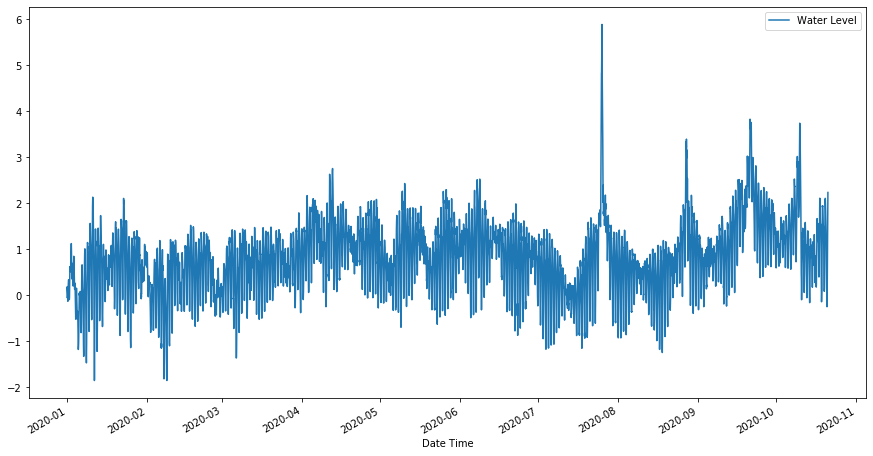

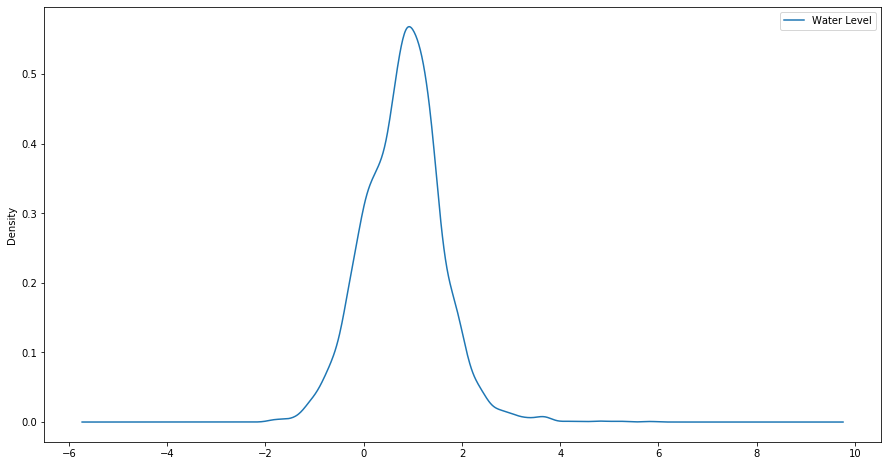

In [179]:
residuals.plot(figsize=(15,8))
residuals.plot(kind='kde', figsize=(15,8))
residuals.describe()

In [166]:
# plt.figure(figsize=(10,4))
# plt.plot(residuals)
# plt.axhline(0, linestyle='--', color='k')
# plt.title('Residuals from SARIMA Model', fontsize=20)
# plt.ylabel('Error', fontsize=16)

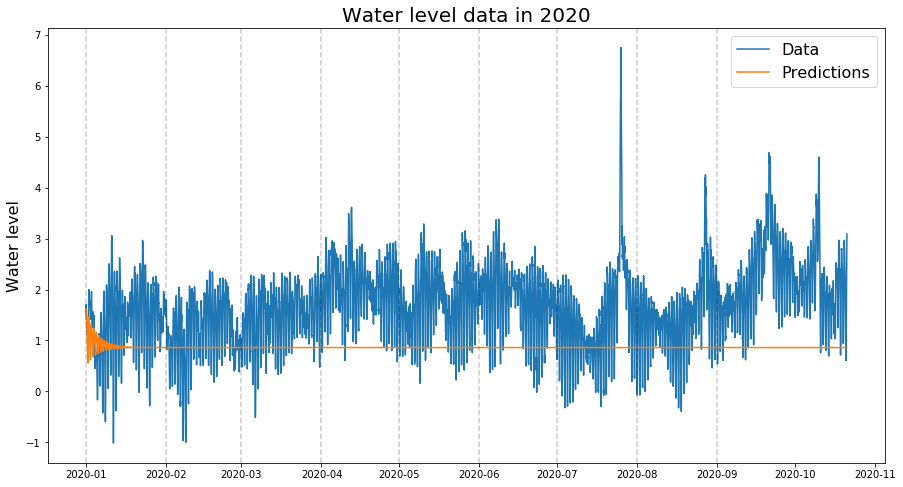

In [180]:
plt.figure(figsize=(15,8))

plt.plot(wl_test)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Water level data in 2020', fontsize=20)
plt.ylabel('Water level', fontsize=16)
for month in range(1,10):
    plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [181]:
from IPython.display import display, clear_output

history = [x for x in wl_train['Water Level'].values]
future = wl_test['Water Level'].copy()
predictions = list()

steps = 24    # a day
total_steps = int(len(wl_test) / steps)

for t in range(total_steps):
    clear_output(wait=True)
    print("{:.2f}%".format(t * 100 / total_steps), sep = ' ', end=' ', flush='True')
    
    model = train_model(history, periodicity=25)
    output = model.forecast(steps)
    yhat = output
    predictions.extend(yhat)
    obs = future[t:t+steps].values
    history.extend(obs)
#     print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

99.66% 

In [182]:
error = mean_squared_error(wl_test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 1.490


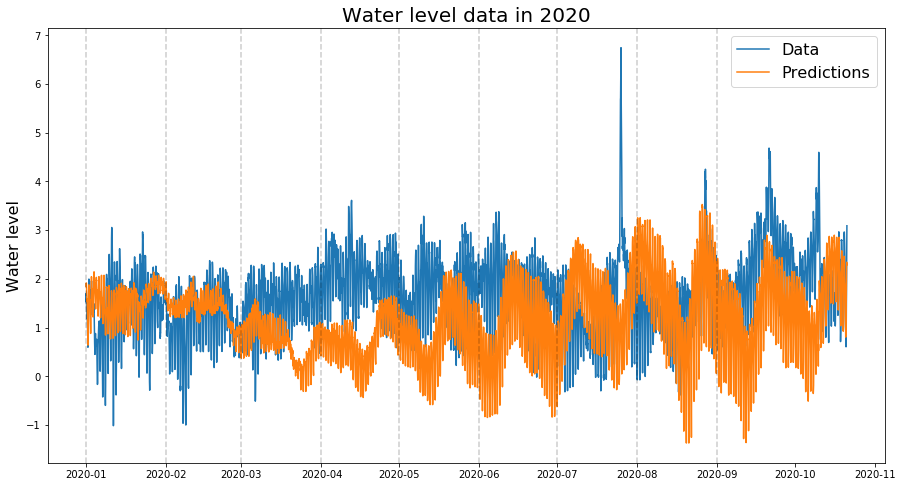

In [183]:
plt.figure(figsize=(15,8))

plt.plot(wl_test)

pred = pd.DataFrame(predictions[1:], columns=['Water Level'], index=wl_test[1:].index)
plt.plot(pred)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Water level data in 2020', fontsize=20)
plt.ylabel('Water level', fontsize=16)
for month in range(1,10):
    plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)